# Peng's updated Kristjan's Bandit Algorithm for HS2

In [1]:
#Imports

%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from scipy.stats import norm
import pickle
import itertools
import datetime


C:\Users\isaac\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
data_loc_pref = "C:/Users/isaac/Documents/Bandit Data/"

In [6]:
#A bandit model, consisting of reward coefficient mean and covariance

# From Peng's 2-1 algorithm; action-centered bandit (algorithm 2)


class model:
    def __init__(self,mu,Sigma):
        self.mu = mu
        self.Sigma = Sigma
        

#THE BANDIT CODE (in class form)

class ContextBandit:
    #Bandit Object
    def __init__(self,nInteract, pc_params,prior_model, gamma, fc_params, f_baseline, f_interact, sigma2 = 1., prior_weight = 1.):
        '''
        pc_params: (pi_min, pi_max) parameters for probability clipping
        prior_model: prior Gaussian model with \mu_\beta, \Sigma_\beta
        gamma: gamma for GP Prior
        fc_params: feedback controller parameters: (\lambda_c, N_c, T_c)
            T_c: maximum number of decision times to count dosage
        f_baseline: baseline feature mapping; f: S \to R^p_1
        f_interact: interaction feature mapping; f_interact: S' \to R^p_2
        sigma2: reward noise estimate (variance)
        prior_weight: how much to weigh prior, set to 1 for full weight
        '''
        #initialize input parameters
        self.nInteract = nInteract
        self.pi_min = pc_params[0]
        self.pi_max = pc_params[1]
        self.gamma = gamma
        self.sigma2 = sigma2

        self.f_baseline = f_baseline
        self.f_interact = f_interact

        self.lambda_c = fc_params[0]
        self.N_c = fc_params[1]
        self.T_c = fc_params[2]

        # self.v = 1e-1 #tuning parameter - multiplier on bandit prior covariances 

        
        #Initialize model to prior data model
        # Mean = prior_weight * prior_model.mu,
        # Cov = I_n + prior_weight * prior_model.Sigma
        
        self.prior_model = prior_model

        # This is mu and Sigma
        self.current_model = model(prior_weight*prior_model.mu,
            (1-prior_weight)*np.eye(len(prior_model.mu)) + prior_weight*prior_model.Sigma)
        # This is mu' and Sigma'
        self.daystart_model = model(prior_weight*prior_model.mu,
            (1-prior_weight)*np.eye(len(prior_model.mu)) + prior_weight*prior_model.Sigma)
        
    def process_context(self, I_T, S_T, N_t):
        '''
        Inputs context for a given decision point,
        updates the current day's model, and returns action probability alpha

        Line 20 of algorithm

        I_T: Current availability
        S_T: Current state
        N_t: Dosage over past T_c decision times; number of messages sent since present minus T_c
        Returns: alpha, probability of taking action 1
        '''
        if I_T == 1:
            current_model = self.current_model
            # Current Posterior mean and variance for interaction term
            mu2 = current_model.mu[:self.nInteract]
            Sigma2 = current_model.Sigma[:self.nInteract,:self.nInteract]

            # Compute probability of unclipped randomization probability
            X_mean = self.f_interact(S_T).T.dot(mu2) - self.lambda_c*(N_t - self.N_c)*(N_t - self.N_c > 0)
            X_var = self.f_interact(S_T).dot(Sigma2.dot(self.f_interact(S_T).T))

            # Actual probability
            pi_t = 1 - norm.cdf(0, X_mean, np.sqrt(X_var))

            if pi_t < self.pi_min:
                alpha = self.pi_min
            elif pi_t > self.pi_max:
                alpha = self.pi_max
            else: 
                alpha = pi_t
            # print(mean, variance, alpha)

        else:
            alpha = 0

        # Update current model to posterior of Gaussian Process
        self.current_model.mu = (1-self.gamma)*self.prior_model.mu + self.gamma * self.current_model.mu
        self.current_model.Sigma = (1 - self.gamma ** 2.) * self.prior_model.Sigma + (self.gamma ** 2.) * self.current_model.Sigma 

        return alpha #probability of taking action 1

        
    ######
    
    def update_model(self, S_T, R_T, A_T, pi_T, I_T, t = 5):
        # Update at end of day
        '''
        At end of day, updates the model given the 
        S_T: states for day T
        R_T: rewards for day T
        A_T: actions for day T
        pi_T: probabilities of action 1 for day T
        I_T: availability for each time point on day T
        t: number of decision points per day, defaults to 5
        '''

        # Set aliases for the current model
        current_model = self.current_model
        current_model.mu = self.daystart_model.mu
        current_model.Sigma = self.daystart_model.Sigma

        for dpt in range(t):
            # If available then:
            if I_T[dpt]:
#                 f_t = np.concatenate([(A_T[dpt] - pi_T[dpt]) * self.f_interact(S_T[dpt]), self.f_baseline(S_T[dpt])], axis=0)
                f_t = np.concatenate([(A_T[dpt]) * self.f_interact(S_T[dpt]), self.f_baseline(S_T[dpt])], axis=0)
            
                Sigma_dot_f_t = np.expand_dims(current_model.Sigma.dot(f_t),1)
                denom = self.sigma2 + f_t.T.dot(Sigma_dot_f_t)
                beta = current_model.mu + (R_T[dpt] - f_t.T.dot(current_model.mu)) / denom * Sigma_dot_f_t
                Omega = current_model.Sigma - 1. / denom * Sigma_dot_f_t.dot(Sigma_dot_f_t.T)
                current_model.mu = self.gamma * beta           + (1 - self.gamma) * self.prior_model.mu
                current_model.Sigma = (self.gamma ** 2.) * Omega + (1 - self.gamma ** 2.) * self.prior_model.Sigma
        
        # New day, new model

        self.daystart_model.mu = current_model.mu.copy()
        self.daystart_model.Sigma = current_model.Sigma.copy()
        
########


In [7]:
# RUN TEST
n_users_test = 20

S_test = np.random.rand(n_users_test,90,5,8)
S_test[:,:,:,0] *= 0
S_test[:,:,:,0] += 1
I_test = np.ones((n_users_test,90,5))

Etas_fit_test = np.array(range(1,Etas_fit.shape[0]+1))*1
resids_test = np.random.normal(size = (n_users_test,90,5),scale=1,loc = 0)

def reward_test(S,A,coef0, coef1, resid):
    nInteract = len(coef1)
    
    predictors = np.concatenate([A * S[1:1+nInteract], S],0)
    
    Eta = np.concatenate([coef1, coef0])
    
    return (resid + np.dot(predictors, Eta))


prior_mdl = model(np.zeros((nInteract+nBaseline,1)),np.eye(nInteract+nBaseline)*100)
fc_params = [0., 2, 5]


regret, prob, action, opt, bandit_cov, bandit_mean, bandit = run_simulation(coef0 = Etas_fit_test[3:11], coef1 = Etas_fit_test[0:3], S_sim = S_test, I_sim = I_test, resids_sim = resids_test, reward_func = reward_test, fc_params = fc_params, prior_model = prior_mdl, gamma = .99, sigma2 = 1.)

NameError: name 'Etas_fit' is not defined

In [4]:
bandit_mean[0,-1,:]
pd.DataFrame(bandit_mean[0]).plot()

NameError: name 'bandit_mean' is not defined

In [4]:
np.mean(bandit_mean,axis=0)[-1,:]

NameError: name 'bandit_mean' is not defined

In [8]:
# HS Analysis Functions

### Aux Functions for reading two different .csv files ###
def read_hs1(yoozer, hs1_file = "../../../Data/suggest-analysis-kristjan.csv"):
    pd_df = pd.read_csv(hs1_file) #'suggest-analysis-kristjan.csv')
    pdf = pd_df[:179]
    snda = pd_df['send.active'] == 1
    snd = pd_df['send'] == 0
    usr = pd_df['user'] == yoozer
    ddf = pd_df[(snda | snd) & usr]
    ddf = ddf.reset_index(drop=True)
    
    
    return ddf,pd_df

def read_hs1_gf(yoozer, hs1_gf_file = '../../../Data/suggest-kristjan.csv'):
    pd_df = pd.read_csv(hs1_gf_file) #'suggest-analysis-kristjan.csv')
    pdf = pd_df[:179]
    snda = pd_df['send.active'] == 1
    snd = pd_df['send'] == 0
    usr = pd_df['user'] == yoozer
    ddf = pd_df[(snda | snd) & usr]
    ddf = ddf.reset_index(drop=True)

    return ddf,pd_df


def nan_equal(a,b):
    return ((a == b) | (np.isnan(a) & np.isnan(b))).all()

def read_data(N, T, t, nBaseline):
    ### Read in Feature vector, Reward Vector, and Action Vector for each user ###
    # Also Standardizes all features

    max_yoozer = N+1

    featVec = np.empty((max_yoozer,T*t, nBaseline))
    featVec.fill(np.nan)

    rewardVec = np.empty((max_yoozer,T*t))
    rewardVec.fill(np.nan)

    actionVec = np.empty((max_yoozer,T*t))
    actionVec.fill(np.nan)

    # Bias term

    for yoozer in range(1,max_yoozer):
    #     print("Processeing User: ", yoozer)

        ddf,pd_df = read_hs1(yoozer)
        #Make features
        #Center and scale
        decision_ind = ddf['decision.index.nogap']
        reward_h = ddf['jbsteps30.log']
        send_any = ddf['send']
        send_active = ddf['send.active']

        assert np.all(send_any == send_active)

        #total_sent = ddf['totalSent']
        # Study day index
        dazze = ddf['study.day.nogap']

        # Number of messages sent in last week
        day_ind  = (ddf['study.day.nogap'] - np.mean(pd_df['study.day.nogap']))/np.std(pd_df['study.day.nogap'])#Number sent in last whatever
        #Add feature for # of week period (hsteps v2) WATCH OUT FOR COLINEARITY WITH INTERCEPT

        # Ohter location indicator
        loc_ind = ddf['loc.is.other']

        # Std deviation of step count in last 7 days
        steps_sd = (ddf['window7.steps60.sd'] - np.mean(pd_df['window7.steps60.sd']))/np.std(pd_df['window7.steps60.sd'])

        # Step count in previous 30 minutes
        state = (ddf['jbsteps30pre.log'] - np.mean(pd_df['jbsteps30pre.log']))/np.std(pd_df['jbsteps30pre.log'])

        # Work location indicator
        #wrk_ind = ddf['location.category'], #loc_ind = ddf['location.category']
        wrk_ind = ddf['loc.is.work'] #compare to string “work”

        # Square root steps yesterday
        steps_yest = (ddf['steps.yesterday.sqrt'] - np.mean(pd_df['steps.yesterday.sqrt']))/np.std(pd_df['steps.yesterday.sqrt'])

        # Temperature, set -1024 as 0
        temp = (ddf['temperature'] - np.mean(pd_df['temperature']))/np.std(pd_df['temperature'])
        temp[ddf['temperature'] == -1024] = 0

        ddfgf,pd_dfgf = read_hs1_gf(yoozer)

        # ?? Unclear what this is
        # Reward: Step count in 30 minutes following decision point
        steps_gf = (np.log(ddfgf['gfsteps30pre'] + .5) - np.mean(np.log(pd_dfgf['gfsteps30pre'] + .5))/np.std(np.log(pd_dfgf['gfsteps30pre']+.5)))

        end_ind = day_ind.shape[0]


        # Set reward, action, and state
        rewardVec[yoozer,:end_ind] = reward_h.astype(float)
        actionVec[yoozer,:end_ind] = send_any.astype(float)

        featVec[yoozer,:end_ind,0].fill(1) # Only fill rows with observations
        featVec[yoozer,:end_ind,1] = day_ind #study.day.nogap
        featVec[yoozer,:end_ind,2] = loc_ind.astype(int) # loc.is.other
        featVec[yoozer,:end_ind,3] = steps_sd.astype(float) # window7.steps60.sd
        featVec[yoozer,:end_ind,4] = state # jbsteps30pre.log
        featVec[yoozer,:end_ind,5] = wrk_ind.astype(int) # loc.is.work
        featVec[yoozer,:end_ind,6] = steps_yest # steps.yesterday.sqrt
        featVec[yoozer,:end_ind,7] = temp.astype(float) # temperature

        # This was included but didn't make too much sense
    #     featVec[yoozer,:end_ind,8] = steps_gf.astype(float)[:day_ind.shape[0]]
    
    ## TREAT DATA ##

    # Drop 0th user, since users are 1-indexed
    featVec = featVec[1:,:,:].copy()
    rewardVec = rewardVec[1:,:].copy()
    actionVec = actionVec[1:,:].copy()

    # Reshape actionVec to have additional 1 dim
    actionVec = actionVec.reshape(actionVec.shape[0],actionVec.shape[1],1)

    # Mean impute featVec where there is an observation
    featVec[~np.isnan(featVec[:,:,1])] = np.nan_to_num(featVec[~np.isnan(featVec[:,:,1])])
    
    return featVec, rewardVec, actionVec

def resid_regression(N, T, t, nBaseline, rewardVec, actionVec, featVec):
    '''Perform Regression on Pooled R ~ A*S' + S to create Residuals'''
    # Actual Dimensions of A and S
    a_dim = 1
    s_dim = nBaseline

    # Copy for notational ease
    R = rewardVec.copy()
    A = actionVec.copy()
    S = featVec.copy()


    # Fit OLS r ~ (a_t s'_t, s_t)^T \eta, where s' are interact terms and s are all baseline
    resid_model = sm.OLS(endog = R.reshape(N*T*t), exog = np.concatenate([(A * S[:,:,1:1+nInteract]), S], 2).reshape((N*T*t,(nInteract + nBaseline))), missing = "drop")
#     resid_model = sm.OLS(endog = R.reshape(N*T*t), exog = np.concatenate([(A * S[:,:,1:1+nInteract]), S[:,:,1:]], 2).reshape((N*T*t,(nInteract + nBaseline-1))), missing = "drop")
    resids_unproc = resid_model.fit().resid

    # Parameters
    Etas_fit = resid_model.fit().params


    ## Fill resids ##

    # Copy shape and location of nans
    resids = rewardVec.copy()

    curr_ind = 0
    for n in range(N):

        old_ind = curr_ind
        curr_ind += R[n][~np.isnan(R[n])].shape[0]

        # Copy in indices
        resids[n][:curr_ind-old_ind] = resids_unproc[old_ind:curr_ind]
    
    return resids, Etas_fit, resid_model


# # Code to Generate Simulated Users
def generate_new_users(resids, A, S, N_new, T_new, T, t, users_to_sample = 10):
    '''
    Generates new random user
    
    Inputs:
        resids: Residuals
        A: Actions
        S: States
        N_new: Int of number of new users to generate from sampling
        T_new: Int of number of days for each new user
    
    Returns:
        resids_new: Matrix of resids for sampled users
        A_new: Matrix of associated actions for sampled users
        S_new: Matrix of associated states for sampled users
        
    *Assumes shapes:
      resids: (N, T * t) 
      A: (N, T * t, )
    '''
    
    # Obtain original dimensions of data from actions A
    N = A.shape[0]

    # Component dims of A and S 
    a_dim = A.shape[2]
    s_dim = S.shape[2]

    # Sample random users from original data
    sampled_user_indices = np.empty((N_new, users_to_sample)).astype(int)

    # Loop to reset sampling without replacement for each new user
    for i in range(N_new):
        sampled_user_indices[i] = np.random.choice(N, size = users_to_sample, replace = False)
    
    # Concatenate resids, A, and S to ensure processing is uniform
    concat_data = np.concatenate([np.expand_dims(resids,2),A,S], axis = 2)
    sampled_users_untreated = np.take(concat_data, sampled_user_indices, 0).reshape(N_new, users_to_sample * T*t, 1 + a_dim + s_dim)
    sampled_users = np.empty((N_new, T_new * t, 1 + a_dim + s_dim))
    
    for i in range(N_new):
        
        # Cast to DataFrame to dropna, reset index to shift datapoints up to be consecutive, takes T_new * t datapoints
        sampled_users[i] = pd.DataFrame(sampled_users_untreated[i]).apply(lambda col: col.dropna().reset_index().iloc[:,-1], axis = 0).as_matrix()[:T_new * t]
        
    # Sampled Generated residuals
    resids_new = sampled_users[:,:,0].reshape(N_new, T_new, t)
    # Sampled actions
    A_new = sampled_users[:,:,1:(1+a_dim)].reshape(N_new, T_new, t, a_dim)
    # Sampled states
    S_new = sampled_users[:,:,(1+a_dim):].reshape(N_new, T_new, t, s_dim)
    
    return resids_new, A_new, S_new



# def reward_func(resid, a, s, Eta, nInteract = 3):
#     '''Basic reward function, can edit for different generative models.
#     Works for multidimensional eta, a, and s, so long as they are of same multidimension.
#     Assumes s has first element as bias for the regression.'''
#     return(resid + np.concatenate([a * np.take(s,range(1,1+nInteract),-1), s], a.ndim-1).dot(Eta))


#Create a reward function from true coefficients, with residuals non-mandatory
def reward_func(S,A,coef0,coef1, resid = None, single_dim = True):
    '''Basic reward function, can edit for different generative models.
    Works for multidimensional eta, a, and s, so long as they are of same multidimension.
    Assumes s has first element as bias for the regression.
    
    Resid must be passed in if not single dim.
    If single dim, can speed out without np.take.'''
    
    nInteract = len(coef1)
    
    if single_dim:
        predictors = np.concatenate([A * S[1:1+nInteract], S], 0)
    else:
        predictors = np.concatenate([A * np.take(S,range(1,1+nInteract),-1), S], 0)
    
    Eta = np.concatenate([coef1, coef0])
    
    if resid is None:
        resid = 0
        
    return(resid + np.dot(predictors, Eta))


def k_fold_split(S, R, A, k = 5):
    '''
    Split S,R,A into k fold train/test batches of roughly size N/k
    '''
    combined = np.copy(np.concatenate([S,np.expand_dims(R,-1),A],axis=-1))
    np.random.shuffle(combined) # Shuffle all together
    N = combined.shape[0]

    tests = []
    trains = []
    
    for i in range(k):
        # For each N/k sized batch, return test and train
        tests.append(combined[int(i*(N/k)):int((i+1)*(N/k))])
        trains.append(np.concatenate([combined[:int(i*(N/k))], combined[int((i+1)*(N/k)):]]))
    
    train_zip = []
    test_zip = []
    
    # Separate back to (S,R,A)
    for train in trains:
        train_zip.append((train[:,:,:S.shape[-1]], train[:,:,S.shape[-1]:1+S.shape[-1]], train[:,:,S.shape[-1]+1:]))
    for test in tests:
        test_zip.append((test[:,:,:S.shape[-1]], test[:,:,S.shape[-1]:1+S.shape[-1]], test[:,:,S.shape[-1]+1:]))
        
    return train_zip, test_zip

In [9]:
## Creating Simulations

# Counts from HS 1
N = 48
T = 41
t = 5
nBaseline = 1+7
nInteract = 3 # Add 1 for bias term

N_new = 55
T_new = 90

S, R, A = read_data(N, T, t, nBaseline)
resids, Etas_fit, resid_model = resid_regression(N, T, t, nBaseline, R, A, S)
resids_new, A_new, S_new = generate_new_users(resids, A, S, N_new, T_new, T, t)
I_new = np.ones_like(A_new)


C:\Users\isaac\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2862: DtypeWarning: Columns (15,16,18,60,61,96,97,112,113) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
resids, Etas_fit, resid_model = resid_regression(N, T, t, nBaseline, R, A, S)

In [8]:
resid_model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     184.3
Date:                Wed, 14 Feb 2018   Prob (F-statistic):               0.00
Time:                        13:47:33   Log-Likelihood:                -14310.
No. Observations:                5961   AIC:                         2.864e+04
Df Residuals:                    5950   BIC:                         2.872e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2118      0.074     -2.882      0.004      -0.356      -0.068
x2            -0.1669      0.094     -1.772      0.076      -0.352       0.018
x3             0.0812      0.081      1.008      0.313      -0.077       0.239
const          3.0449      0.077     39.790      0.000       2.895       3.195
x4            -0.0231      0.043     -0.533      0.594      -0.108       0.062
x5             0.0644      0.091      0.708      0.479      -0.114       0.243
x6             0.1890      0.047      4.034      0.000       0.097       0.281
x7             1.3621      0.035     38.603      0.000       1.293       1.431
x8             0.3014      0.123      2.442      0.015       0.059       0.543
x9             0.2311      0.036      6.397      0.000       0.160       0.302
x10            0.3830      0.258      1.483      0.138      -0.123       0.889
==============================================================================
Omnibus:                      279.949   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              149.952
Skew:                          -0.221   Prob(JB):                     2.74e-33
Kurtosis:                       2.361   Cond. No.                         9.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
resid_model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     184.3
Date:                Wed, 14 Feb 2018   Prob (F-statistic):               0.00
Time:                        13:47:33   Log-Likelihood:                -14310.
No. Observations:                5961   AIC:                         2.864e+04
Df Residuals:                    5950   BIC:                         2.872e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2118      0.074     -2.882      0.004      -0.356      -0.068
x2            -0.1669      0.094     -1.772      0.076      -0.352       0.018
x3             0.0812      0.081      1.008      0.313      -0.077       0.239
const          3.0449      0.077     39.790      0.000       2.895       3.195
x4            -0.0231      0.043     -0.533      0.594      -0.108       0.062
x5             0.0644      0.091      0.708      0.479      -0.114       0.243
x6             0.1890      0.047      4.034      0.000       0.097       0.281
x7             1.3621      0.035     38.603      0.000       1.293       1.431
x8             0.3014      0.123      2.442      0.015       0.059       0.543
x9             0.2311      0.036      6.397      0.000       0.160       0.302
x10            0.3830      0.258      1.483      0.138      -0.123       0.889
==============================================================================
Omnibus:                      279.949   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              149.952
Skew:                          -0.221   Prob(JB):                     2.74e-33
Kurtosis:                       2.361   Cond. No.                         9.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Checklist #
1)  Split
2)  Train
3)  Optimize
(Run )
3)  Validate

## Compute quality metrics ##

1. Plot time series of $\pi_t(1 | S_t)$ for all $t$, for some users.
2.	Examine probs i.e. $\pi_t(1 | S_t)$ vs. $opt_t(S_t)$, for all $t$, for some users.
    a.	$opt_t(S_t) = 0.8\{\text{optimal action is 1 in context } S_t\} + 0.2 \{\text{optimal action is 0 in context } S_t\}$
3.	Examine $|\pi_t(1 | S_t) - opt_t(S_t)|$ for all users, averaging over all N users for each time point $t$.
4.	Examine $|\pi_t(1 | S_t) - opt_t(S_t)|$ for all users, histogram of each user's mean.
5.	Examine cumulative regret over $t$

    a.  Plot average over all users
    
    b.  Plot time series for individual users
    
    c.	Regret = Expected reward of bandit - reward of optimal policy
    
6.	Compute number of actions taken each $t$

    a.	Plot histogram across all days for each of several simulated users
    
    b.	Average number of actions taken across all $N$ users, plot average versus $t$



In [10]:
# VARIABLES FROM ABOVE CELL

S_new # Baseline States for simulated users
resids_new # Residuals; note this does not match up with Kristjan's Eta definition (he treats this as baseline OLS coefficient)

# Etas[0:3] is action*interact features
# Etas[3] is state bias (1's)
# Etas[4:11] are baseline features
Etas_fit

array([-0.21181203, -0.16692167,  0.08116949,  3.04487594, -0.02305797,
        0.06443497,  0.18900795,  1.36208089,  0.30135504,  0.23107337,
        0.38301622])

In [11]:
#A simulation of above standard model.

def f_baseline(featVec):
    return featVec

def f_interact(featVec):
    return featVec[1:1+3]


def run_simulation(coef0, coef1, S_sim, I_sim, resids_sim, reward_func, prior_model,
                   fc_params, nInteract = 3, nBaseline = 7+1, pc_params = [.2, .8],
                   f_baseline = f_baseline, f_interact = f_interact,
                   gamma = 1., sigma2 = 1. , T = 90, t = 5, no_resid_flag = False):
    '''
    coef0: Reward coefficients for baseline (PHI), first element is bias term
    coef1: Reward coefficients for interaction (THETA); note that concatenated, [THETA, PHI] = Eta
    S_sim: simulated states
    I_sim: simulated availabilities; 1 = available, 0 = unavailable
    resids_sim: Residuals of simulated users
    reward_func: reward function, must have type reward(featVec, action, coef0, coef1, resid)
    nInteract: Number of interaction features
    nBaseline: Number of baseline features
    params: Bandit parameters; [minprob, maxprob, priorweight]
    T: days of study
    t: decision points per day
    no_resid_flag: If True will substitute 0 for residuals, if False will use true residuals
    '''
    N = S_sim.shape[0]
    assert T == S_sim.shape[1]
    assert t == S_sim.shape[2]
    assert nBaseline == S_sim.shape[3]
    
    #creating variables for saving history of what we do
    regret = np.empty((N, T, t))
    prob  = np.empty((N, T, t))
    action = np.empty((N, T, t))
    opt = np.empty((N, T, t))
    regret.fill(np.nan)
    prob.fill(np.nan)
    action.fill(np.nan)
    opt.fill(np.nan)
    
    # Containers for bandit parameters
    bandit_covs = np.empty((N, T,t, nInteract+nBaseline, nInteract+nBaseline))
    bandit_covs.fill(np.nan)
    bandit_means = np.empty((N, T,t, nInteract+nBaseline))
    bandit_means.fill(np.nan)

    for sim_user_index in range(N):

        #Create a bandit object for each user
        bandit = ContextBandit(nInteract, pc_params, prior_model, gamma, fc_params, f_baseline, f_interact, sigma2) #Create and initialize bandit

        #Cycle thru days
        for day in range(T):

            rwd = np.zeros(t)
#             featVec = np.zeros((nBaseline,t))
            #Cycle thru decision points in each day
            for dpt in range(t):
                #Generate random state vector 
#                 featVec[:,dpt] = S_sim[sim_user_index, day, dpt]
                user_resid = resids_sim[sim_user_index, day, dpt]
                if no_resid_flag:
                    user_resid = 0
                    
                #Get action probability from bandit
                
                # prob[] is the probability of taking action 1 at current decision point, i.e. \pi_t(1|s_t) in the doc (Quality metrics 1&2).
                # featInteract = S_sim[sim_user_index, day, dpt, 1:1+nInteract] #only use the interaction features, but first element is bias
                if False: #Do nothing
                    prob[sim_user_index, day, dpt] = 0
                else: #Use bandit
                    # Count dosage from previous N_c days
                    N_t = np.sum(action[sim_user_index].reshape(-1)[max(0,day*t + dpt - bandit.N_c):day*t + dpt])
                    # Compute clipped probability
                    prob[sim_user_index, day, dpt] = bandit.process_context(
                    I_sim[sim_user_index, day, dpt], S_sim[sim_user_index, day, dpt], N_t)


                #Choose action based on probability, i.e. do the randomization
                if np.random.rand() < prob[sim_user_index, day, dpt]:
                    action[sim_user_index, day, dpt] = 1
                else:
                    action[sim_user_index, day, dpt] = 0

                #Receive reward from the universe. 
                rwd[dpt] = reward_func(S_sim[sim_user_index, day, dpt], action[sim_user_index, day, dpt], coef0, coef1, user_resid)


                #What was expected regret given probability chosen by bandit?
                #(easy to do since we know the \theta coefficients, reward under action 1 is reward under action 0 plus \theta^T s_t, and vice versa)
                rwd0 = reward_func(S_sim[sim_user_index, day, dpt], 0, coef0, coef1, user_resid) # do we want to include user_resid here or use default 0?
                rwd1 = reward_func(S_sim[sim_user_index, day, dpt], 1, coef0, coef1, user_resid)

                #Expected reward under bandit policy
                rwdExp = prob[sim_user_index, day, dpt]*rwd1 + (1-prob[sim_user_index, day, dpt])*rwd0

                #Regret is difference between optimal reward and the reward we got
                #"Optimal" reward is restricted based on the min/max allowed probabilities
                #ISAAC: THIS IS THE REGRET AT THE CURRENT DECISION POINT. Cumulative regret is formed by summing this up from time 0 to the current time.
                regret[sim_user_index, day, dpt] = max(pc_params[0]*rwd0 + pc_params[1]*rwd1, pc_params[0]*rwd1 + pc_params[1]*rwd0) - rwdExp


                # Record optimal probability; sometimes reward will be same between actions
                opt[sim_user_index, day, dpt] = 0.8 * (rwd1 > rwd0) + 0.2 * (rwd1 <= rwd0)

            #Perform bandit updates at end of day
            for dpt in range(t):
                bandit_covs[sim_user_index, day, dpt] = bandit.daystart_model.Sigma
#                 print(bandit_means[sim_user_index, day, dpt].shape, bandit.daystart_model.mu.flatten().shape)
                bandit_means[sim_user_index, day, dpt] = bandit.daystart_model.mu.flatten()
                bandit.update_model(S_sim[sim_user_index, day], rwd, action[sim_user_index, day], prob[sim_user_index, day], I_sim[sim_user_index, day])
                #bandit.update_model(np.concatenate([[1],featVec[1:nInteract+1,dpt],featVec[1+nInteract:,]]),rwd[dpt],np.zeros(nInteract),action[sim_user_index, day, dpt],prob[sim_user_index, day, dpt])


    return regret.reshape((N,T*t)), prob.reshape((N,T*t)), action.reshape((N,T*t)), opt.reshape((N, T*t)), bandit_covs.reshape((N,T*t, nInteract+nBaseline,nInteract+nBaseline)), bandit_means.reshape((N,T*t, nInteract+nBaseline)), bandit


In [184]:
prior_mdl = model(np.zeros((nInteract+nBaseline,1)),np.eye(nInteract+nBaseline))
fc_params = [1., 2, 5]


regret, prob, action, opt, bandit_cov, bandit_mean, bandit = run_simulation(coef0 = Etas_fit[3:11], coef1 = Etas_fit[0:3], S_sim = S_new, I_sim = I_new, resids_sim = resids_new, reward_func = reward_func, fc_params = fc_params, prior_model = prior_mdl, gamma = 0.99, sigma2 = np.nanstd(resids))

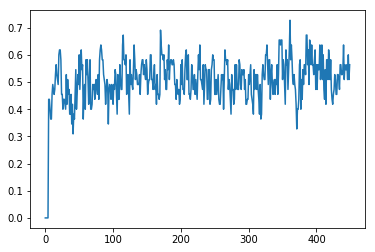

In [185]:
pd.DataFrame(prob.T).applymap(lambda col: col in [0.2, 0.8]).mean(axis=1).plot()

# (Preliminary Testing)

In [24]:
# TEST GAMMA
prior_mdl = model(np.zeros((nInteract+nBaseline,1)),np.eye(nInteract+nBaseline))
fc_params = [1., 5, 10]

regrets = []
probs = []
actions = []
bandit_covs = []
bandi_means = []
gammas = [0.01,0.1,0.2,0.3,0.5,0.6,0.7,0.8,0.9,0.95,0.99,1.]
for gamma in gammas:
    print(gamma)
    regret, prob, action, bandit_cov, bandit_mean, bandit = run_simulation(coef0 = Etas_fit[3:11], coef1 = Etas_fit[0:3], S_sim = S_new, I_sim = I_new, resids_sim = resids_new, reward_func = reward_func, fc_params = fc_params, prior_model = prior_mdl, gamma = gamma)
    regrets.append(regret)
    probs.append(prob)
    actions.append(action)
    bandit_covs.append(bandit_cov)
    bandit_means.append(bandit_mean)

0.01
0.1
0.2
0.3
0.5
0.6
0.7
0.8
0.9
0.95
0.99
1.0


In [39]:
for i in range(len(regrets)):
    np.save('results/regrets' + str(i) +'.npy',regrets[i])
    np.save('results/probs' + str(i) +'.npy',probs[i])
    np.save('results/actions' + str(i) +'.npy',actions[i])
#     np.save('results/bandit_covs' + str(i) +'.npy',bandit_covs[i])
    np.save('results/bandit_means' + str(i) +'.npy',bandit_means[i])
    

In [58]:
regret_results = []
prob_results = []
action_results = []
bandit_cov_results = []
bandit_mean_results = []


for i in range(900):
    regret_results.append(np.load("results/regrets" + str(i) + '.npy'))
    prob_results.append(np.load("results/probs" + str(i) + '.npy'))
    action_results.append(np.load("results/actions" + str(i) + '.npy'))
    bandit_cov_results.append(np.load("results/bandit_covs" + str(i) + '.npy'))
    bandit_mean_results.append(np.load("results/bandit_means" + str(i) + '.npy'))

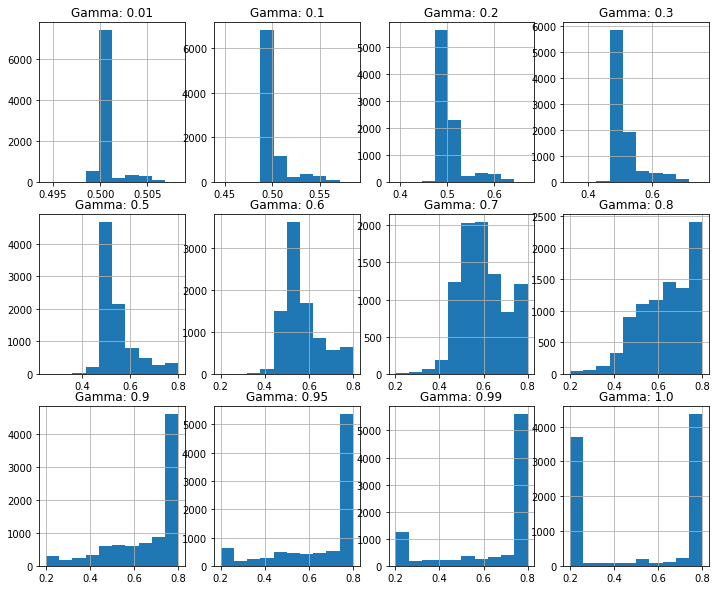

In [43]:
fig,axes = plt.subplots(3,4,figsize = (12,10))
for prob,ax,gamma in zip(probs,axes.flat,gammas):
#     fig,ax = plt.subplots()
    pd.Series(prob.flatten()).hist(ax = ax)
    ax.set_title("Gamma: "+ str(gamma))

In [12]:
# TEST All
prior_mdl = model(np.zeros((nInteract+nBaseline,1)),np.eye(nInteract+nBaseline))

sigmas = [0.10,0.5, 1., np.nanstd(resids),10.]
gammas = [0.5,0.7,0.8,0.9,0.99,1.]
lambdas = [0.25, 0.5, 0.75, 1.,5.,10.,25.,100.]
N_c_mults = [0.25, 0.5, 0.75]
T_cs = [5, 10, 20, 50, 70]
T_cs_new = [30, 90,120,140,180,210,420,630]

regrets = np.empty((len(sigmas), len(gammas), len(lambdas), len(N_c_mults), len(T_cs),N_new, T_new*t))
probs = np.empty((len(sigmas), len(gammas), len(lambdas), len(N_c_mults), len(T_cs),N_new, T_new*t))
actions = np.empty((len(sigmas), len(gammas), len(lambdas), len(N_c_mults), len(T_cs),N_new, T_new*t))
opts = np.empty((len(sigmas), len(gammas), len(lambdas), len(N_c_mults), len(T_cs),N_new, T_new*t))
bandit_means = np.empty((len(sigmas), len(gammas), len(lambdas), len(N_c_mults), len(T_cs),N_new, T_new*t, 11))

for a in range(len(sigmas)):
    sigma = sigmas[a]
    for b in range(len(gammas)):
        print(str(((a*len(gammas) + b)/(len(gammas)*len(sigmas)))*100) + "%, " + str(datetime.datetime.now()))
        gamma = gammas[b]
        for c in range(len(lambdas)):
            lamb = lambdas[c]
            for d in range(len(N_c_mults)):
                N_c_mult = N_c_mults[d]
                for e in range(len(T_cs)):
                    T_c = T_cs[e]
                    fc_params = [lamb, int(N_c_mult*T_c), T_c]
                    
                    regret, prob, action, opt, bandit_cov, bandit_mean, bandit = run_simulation(coef0 = Etas_fit[3:11], coef1 = Etas_fit[0:3], S_sim = S_new, I_sim = I_new, resids_sim = resids_new, reward_func = reward_func, fc_params = fc_params, prior_model = prior_mdl, gamma = gamma, sigma2=sigma)
                    regrets[a,b,c,d,e] = regret
                    probs[a,b,c,d,e] = prob
                    actions[a,b,c,d,e] = action
                    opts[a,b,c,d,e] = opt
                    bandit_means[a,b,c,d,e] = bandit_mean


# start = datetime.datetime.now()
# for sigma in sigmas:
#     print(sigma, str(datetime.datetime.now()), (datetime.datetime.now() - now).seconds)
#     for gamma in gammas:
#         print(gamma)
#         for lamb in lambdas:
#             for N_c_mult in N_c_mults:
#                 for T_c in T_cs:
#                     start
# #                     print(sigma, gamma, lamb, N_c_mult, T_c)

#                     fc_params = [lamb, int(N_c_mult*T_c), T_c]
#                     regret, prob, action, opt, bandit_cov, bandit_mean, bandit = run_simulation(coef0 = Etas_fit[3:11], coef1 = Etas_fit[0:3], S_sim = S_new, I_sim = I_new, resids_sim = resids_new, reward_func = reward_func, fc_params = fc_params, prior_model = prior_mdl, gamma = gamma, sigma2=sigma)
#                     regrets.append(regret)
#                     probs.append(prob)
#                     actions.append(action)
#                     opts.append(opt)
#                     bandit_covs.append(bandit_cov)
#                     bandit_means.append(bandit_mean)                
#     start = datetime.datetime.now()

0.0%, 2018-02-10 03:12:44.784739
3.3333333333333335%, 2018-02-10 03:29:12.841507
6.666666666666667%, 2018-02-10 03:45:42.688777
10.0%, 2018-02-10 04:01:42.254971
13.333333333333334%, 2018-02-10 04:17:43.620097
16.666666666666664%, 2018-02-10 04:33:31.770526
20.0%, 2018-02-10 04:49:33.094560
23.333333333333332%, 2018-02-10 05:05:58.954041
26.666666666666668%, 2018-02-10 05:20:55.862711
30.0%, 2018-02-10 05:35:30.719700
33.33333333333333%, 2018-02-10 05:50:20.435054
36.666666666666664%, 2018-02-10 06:05:26.609472
40.0%, 2018-02-10 06:20:08.454316
43.333333333333336%, 2018-02-10 06:34:51.001693
46.666666666666664%, 2018-02-10 06:49:35.196113
50.0%, 2018-02-10 07:04:10.206514
53.333333333333336%, 2018-02-10 07:18:49.709773
56.666666666666664%, 2018-02-10 07:33:41.615072
60.0%, 2018-02-10 07:48:52.986876
63.33333333333333%, 2018-02-10 08:04:06.411419
66.66666666666666%, 2018-02-10 08:19:24.306297
70.0%, 2018-02-10 08:34:34.120180
73.33333333333333%, 2018-02-10 08:49:48.297560
76.66666666666

In [55]:
# TEST GOOD PRIOR
prior_mdl = model(np.expand_dims(Etas_fit,axis=1),np.eye(nInteract+nBaseline))

prior_cov_mult = [0.1,0.5,1.,2.,10.]
sigmas = [0.10,0.5, 1., np.nanstd(resids),10.]
gammas = [0.5,0.7,0.8,0.9,0.99,1.]
lambdas = [0.25, 0.5, 0.75, 1.,5.,10.,25.,100.]
N_c_mults = [0.25, 0.5, 0.75]
T_cs = [5, 10, 20, 50, 70]
T_cs_new = [30, 90,120,140,180,210,420,630]

regrets_good = np.empty((len(sigmas), len(gammas), len(lambdas), len(N_c_mults), len(T_cs),N_new, T_new*t))
probs_good = np.empty((len(sigmas), len(gammas), len(lambdas), len(N_c_mults), len(T_cs),N_new, T_new*t))
actions_good = np.empty((len(sigmas), len(gammas), len(lambdas), len(N_c_mults), len(T_cs),N_new, T_new*t))
opts_good = np.empty((len(sigmas), len(gammas), len(lambdas), len(N_c_mults), len(T_cs),N_new, T_new*t))
bandit_means_good = np.empty((len(sigmas), len(gammas), len(lambdas), len(N_c_mults), len(T_cs),N_new, T_new*t, 11))

for a in range(len(sigmas)):
    sigma = sigmas[a]
    for b in range(len(gammas)):
        print(str(((a*len(gammas) + b)/(len(gammas)*len(sigmas)))*100) + "%, " + str(datetime.datetime.now()))
        gamma = gammas[b]
        for c in range(len(lambdas)):
            lamb = lambdas[c]
            for d in range(len(N_c_mults)):
                N_c_mult = N_c_mults[d]
                for e in range(len(T_cs)):
                    T_c = T_cs[e]
                    fc_params = [lamb, int(N_c_mult*T_c), T_c]
                    
                    regret, prob, action, opt, bandit_cov, bandit_mean, bandit = run_simulation(coef0 = Etas_fit[3:11], coef1 = Etas_fit[0:3], S_sim = S_new, I_sim = I_new, resids_sim = resids_new, reward_func = reward_func, fc_params = fc_params, prior_model = prior_mdl, gamma = gamma, sigma2=sigma)
                    regrets_good[a,b,c,d,e] = regret
                    probs_good[a,b,c,d,e] = prob
                    actions_good[a,b,c,d,e] = action
                    opts_good[a,b,c,d,e] = opt
                    bandit_means_good[a,b,c,d,e] = bandit_mean

0.0%, 2018-02-11 01:13:26.494952
3.3333333333333335%, 2018-02-11 01:30:23.912794
6.666666666666667%, 2018-02-11 01:45:38.032633
10.0%, 2018-02-11 02:00:38.727168
13.333333333333334%, 2018-02-11 02:15:34.971019
16.666666666666664%, 2018-02-11 02:30:24.595465
20.0%, 2018-02-11 02:45:09.742227
23.333333333333332%, 2018-02-11 02:59:59.847230
26.666666666666668%, 2018-02-11 03:14:55.172121
30.0%, 2018-02-11 03:29:46.160977
33.33333333333333%, 2018-02-11 03:44:42.426367
36.666666666666664%, 2018-02-11 03:59:40.069449
40.0%, 2018-02-11 04:14:23.777489
43.333333333333336%, 2018-02-11 04:29:19.745593
46.666666666666664%, 2018-02-11 04:44:22.539352
50.0%, 2018-02-11 04:59:15.802756
53.333333333333336%, 2018-02-11 05:14:10.889010
56.666666666666664%, 2018-02-11 05:29:00.042011
60.0%, 2018-02-11 05:43:44.143038
63.33333333333333%, 2018-02-11 05:58:42.556143
66.66666666666666%, 2018-02-11 06:13:43.943159
70.0%, 2018-02-11 06:28:39.411020
73.33333333333333%, 2018-02-11 06:43:40.083136
76.66666666666

In [56]:
np.save("regrets_good.npy",regrets_good)
np.save("probs_good.npy",probs_good)
np.save("actions_good.npy",actions_good)
np.save("opts_good.npy",opts_good)
np.save("bandit_means_good.npy",bandit_means_good)

In [57]:
# TEST BAD PRIOR
prior_mdl = model(np.random.normal(size = ((nInteract+nBaseline,1)),scale = 2),np.eye(nInteract+nBaseline))

prior_cov_mult = [0.1,0.5,1.,2.,10.]
sigmas = [0.10,0.5, 1., np.nanstd(resids),10.]
gammas = [0.5,0.7,0.8,0.9,0.99,1.]
lambdas = [0.25, 0.5, 0.75, 1.,5.,10.,25.,100.]
N_c_mults = [0.25, 0.5, 0.75]
T_cs = [5, 10, 20, 50, 70]
T_cs_new = [30, 90,120,140,180,210,420,630]

regrets_bad = np.empty((len(sigmas), len(gammas), len(lambdas), len(N_c_mults), len(T_cs),N_new, T_new*t))
probs_bad = np.empty((len(sigmas), len(gammas), len(lambdas), len(N_c_mults), len(T_cs),N_new, T_new*t))
actions_bad = np.empty((len(sigmas), len(gammas), len(lambdas), len(N_c_mults), len(T_cs),N_new, T_new*t))
opts_bad = np.empty((len(sigmas), len(gammas), len(lambdas), len(N_c_mults), len(T_cs),N_new, T_new*t))
bandit_means_bad = np.empty((len(sigmas), len(gammas), len(lambdas), len(N_c_mults), len(T_cs),N_new, T_new*t, 11))

for a in range(len(sigmas)):
    sigma = sigmas[a]
    for b in range(len(gammas)):
        print(str(((a*len(gammas) + b)/(len(gammas)*len(sigmas)))*100) + "%, " + str(datetime.datetime.now()))
        gamma = gammas[b]
        for c in range(len(lambdas)):
            lamb = lambdas[c]
            for d in range(len(N_c_mults)):
                N_c_mult = N_c_mults[d]
                for e in range(len(T_cs)):
                    T_c = T_cs[e]
                    fc_params = [lamb, int(N_c_mult*T_c), T_c]
                    
                    regret, prob, action, opt, bandit_cov, bandit_mean, bandit = run_simulation(coef0 = Etas_fit[3:11], coef1 = Etas_fit[0:3], S_sim = S_new, I_sim = I_new, resids_sim = resids_new, reward_func = reward_func, fc_params = fc_params, prior_model = prior_mdl, gamma = gamma, sigma2=sigma)
                    regrets_bad[a,b,c,d,e] = regret
                    probs_bad[a,b,c,d,e] = prob
                    actions_bad[a,b,c,d,e] = action
                    opts_bad[a,b,c,d,e] = opt
                    bandit_means_bad[a,b,c,d,e] = bandit_mean

0.0%, 2018-02-11 08:46:38.815370
3.3333333333333335%, 2018-02-11 09:03:12.528293
6.666666666666667%, 2018-02-11 09:19:57.066456
10.0%, 2018-02-11 09:36:40.569667
13.333333333333334%, 2018-02-11 09:53:20.026593
16.666666666666664%, 2018-02-11 10:10:00.092119
20.0%, 2018-02-11 10:26:23.837418
23.333333333333332%, 2018-02-11 10:42:17.308816
26.666666666666668%, 2018-02-11 10:57:50.269377
30.0%, 2018-02-11 11:13:44.940148
33.33333333333333%, 2018-02-11 11:29:35.251825
36.666666666666664%, 2018-02-11 11:45:26.993806
40.0%, 2018-02-11 12:00:56.664153
43.333333333333336%, 2018-02-11 12:16:51.375705
46.666666666666664%, 2018-02-11 12:32:24.700294
50.0%, 2018-02-11 12:47:44.917131
53.333333333333336%, 2018-02-11 13:03:13.609807
56.666666666666664%, 2018-02-11 13:19:08.647604
60.0%, 2018-02-11 13:34:48.258612
63.33333333333333%, 2018-02-11 13:50:47.403398
66.66666666666666%, 2018-02-11 14:06:51.944203
70.0%, 2018-02-11 14:22:44.460240
73.33333333333333%, 2018-02-11 14:38:53.848669
76.66666666666

In [58]:
np.save("regrets_bad.npy",regrets_bad)
np.save("probs_bad.npy",probs_bad)
np.save("actions_bad.npy",actions_bad)
np.save("opts_bad.npy",opts_bad)
np.save("bandit_means_bad.npy",bandit_means_bad)

# Load and analyze results

In [24]:
# QM 1
def plot_QM1(regret, prob, action, opt, y_size = 5, x_size = 10, num_show = 4, alpha = 0.75):
    ''' Time series of probs (\pi_t(1 | S_t)) for all t,
    for num_show users at a time
    '''
    N_new = prob.shape[0]
    num_plots = int(np.ceil(N_new/num_show))
    fig,ax = plt.subplots(num_plots, 1, figsize = (x_size, y_size*num_plots))
    for i in range(num_plots):
        pd.DataFrame(prob.T).iloc[:,int(i*num_show):int((i+1)*num_show)].plot(ax = ax[i], alpha = alpha)
        ax[i].set_title('Action Probability over Decision Point for Given Users')
        ax[i].set_ylabel('\pi_t(1 | S_t)')
        ax[i].set_xlabel('t (Decision Point)')
        
# QM 1b
def plot_QM1b(regret, prob, action, opt, y_size = 5, x_size = 10):
    ''' Time series of probs (\pi_t(1 | S_t)) for all t,
    for num_show users at a time
    '''
    fig,ax = plt.subplots(1, 1, figsize = (x_size, y_size))
    pd.DataFrame(prob.T).mean(axis=1).plot(ax = ax)
    ax.set_title('Average Action Probability over Decision Points for All Users')
    ax.set_ylabel('\pi_t(1 | S_t)')
    ax.set_xlabel('t (Decision Point)')

# QM 2
def plot_QM2(regret, prob, action, opt, y_size = 5, x_size = 10, user_inds_to_show = list(range(5)), alpha = 0.75):
    ''' Time series of probs (\pi_t(1 | S_t)) vs opt_t(S_t) for all t,
    for some users at a time
    
    opt_t(S_t) = 0.8{optimal action is 1 in context S_t} + 0.2 {optimal action is 0 in context S_t}
    '''
    N_new = prob.shape[0]
    num_plots = len(user_inds_to_show)
    fig,ax = plt.subplots(num_plots, 1, figsize = (x_size, y_size*num_plots))
    
    for user,i in zip(user_inds_to_show,range(N_new)):
        pd.DataFrame({"opt" : opt[i],"prob": prob[i]}).plot(ax = ax[i], alpha = alpha)
        ax[i].set_title('Action Probability vs Optimal Probability for User ' + str(user))
        ax[i].set_ylabel('Probability')
        ax[i].set_xlabel('t (Decision Point)')
        
# QM 3
def plot_QM3(regret, prob, action, opt, y_size = 5, x_size = 10):
    ''' Time series of |probs (\pi_t(1 | S_t)) - opt_t(S_t)| for all t
    averaged over all users
    
    opt_t(S_t) = 0.8{optimal action is 1 in context S_t} + 0.2 {optimal action is 0 in context S_t}
    '''
    
    fig,ax = plt.subplots(1, 1, figsize = (x_size, y_size))
    
    pd.DataFrame({"mean": np.mean(np.abs(prob - opt),axis=0), "std": np.std(np.abs(prob - opt),axis=0)}).plot(ax = ax ) #, legend = False)
    ax.set_title('|Action Probability - Optimal Probability| Averaged over all ' + str(prob.shape[0]) + ' Users')
    ax.set_ylabel('Probability Difference')
    ax.set_xlabel('t (Decision Point)')

        
# QM 4
def plot_QM4(regret, prob, action, opt, y_size = 5, x_size = 10):
    ''' Histogram of |probs (\pi_t(1 | S_t)) - opt_t(S_t)| averaged over all t for all users
    averaged over all users
    
    opt_t(S_t) = 0.8{optimal action is 1 in context S_t} + 0.2 {optimal action is 0 in context S_t}
    '''
    fig,ax = plt.subplots(1, 1, figsize = (x_size, y_size))
    pd.DataFrame(np.mean(np.abs(prob - opt),axis=1))
    pd.DataFrame(np.mean(np.abs(prob - opt),axis=1)).hist(ax = ax)
    ax.set_title('|Action Probability - Optimal Probability| Averaged over all t for all ' + str(prob.shape[0]) + ' Users')
    ax.set_xlabel('Probability Difference')
    
# QM 5
def plot_QM5(regret, prob, action, opt, y_size = 5, x_size = 10, num_show = 10, alpha = 0.75):
    ''' Time series of cumulative regret averaged over all t for all users
    '''
    N_new = regret.shape[0]
    num_plots = int(np.ceil(N_new/num_show))
    fig,ax = plt.subplots(num_plots, 1, figsize = (x_size, y_size*num_plots))
    df_out = pd.DataFrame(np.cumsum(regret,axis = 1).T)
    df_mean = np.mean(df_out,axis=1)
    df_mean.columns = ["Mean"]
    for i in range(num_plots):
        df_mean.plot(ax = ax[i], lw = 5)
        df_out.iloc[:,int(i*num_show):int((i+1)*num_show)].plot(ax = ax[i], alpha = alpha)
        ax[i].set_title('Action Probability over Decision Point for Given Users; Thick Blue is Mean over All Users')
        ax[i].set_ylabel('Regret')
        ax[i].set_xlabel('t (Decision Point)') 
    
# QM 6a
def plot_QM6a(regret, prob, action, opt, y_size = 3, x_size = 15, hists_per_row = 5, alpha = 0.75):
    ''' Time Series of number of actions taken across all N users for all t
    '''
    N_new = prob.shape[0]
    num_plots = int(np.ceil(N_new/hists_per_row))
    fig,axes = plt.subplots(num_plots, hists_per_row, figsize = (x_size, y_size*num_plots), sharey=True)
    df_out = pd.DataFrame(np.sum(action.reshape((N_new, T_new, t)),axis=-1).T)
    for i,ax in zip(range(N_new),axes.flatten()):
        df_out.loc[:,i].hist(ax = ax, bins = t+t)
        ax.set_title("User " + str(i))
        ax.set_ylabel('Count')
        ax.set_xlabel('Num Actions')
        
        
    st = fig.suptitle("Action Probability over Decision Point for Each User")
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

# QM 6b
def plot_QM6b(regret, prob, action, opt, y_size = 5, x_size = 10, num_show = 4, alpha = 0.75):
    ''' Time Series of number of actions per day taken across all N users for all t
    '''
    fig,ax = plt.subplots(1, 1, figsize = (x_size, y_size))
    pd.DataFrame(np.mean(np.sum(action.reshape((N_new, T_new, t)),axis=-1),axis=0)).plot(ax = ax, legend = False)
    ax.set_title('Number of Actions Per Day Averaged Over All Users')
    ax.set_ylabel('Num Actions')
    ax.set_xlabel('Day')

# QM 6c
def plot_QM6c(regret, prob, action, opt, y_size = 3, x_size = 5):
    ''' Time Series of number of actions taken across all N users for all t
    '''
    fig,ax = plt.subplots(1, 1, figsize = (x_size, y_size))
    ax.hist((np.sum(action.reshape((N_new, T_new, t)),axis=-1)).flatten(),align='left')
    ax.set_title('Number of Actions Per Day For All Users')
    ax.set_ylabel('Count')
    ax.set_xlabel('Num Actions')
    
    
def params_print(a,b,c,d,e):
    out = "|"
    if a is not None:
        out += "Sigma: " + str(sigmas[a]) + "|"
    if b is not None:
        out += "Gamma: " + str(gammas[b]) + "|"
    if c is not None:
        out += "Lambda: " + str(lambdas[c]) + "|"
    if d is not None:
        out += "N_c_mult: " + str(N_c_mults[d]) + "|"
    if e is not None:
        out += "T_c: " + str(T_cs[e]) + "|"
        
    return out

In [12]:
regrets = np.load(data_loc_pref + "regrets.npy")
probs = np.load(data_loc_pref + "probs.npy")
actions = np.load(data_loc_pref + "actions.npy")
opts = np.load(data_loc_pref + "opts.npy")
bandit_means = np.load(data_loc_pref + "bandit_means.npy")



In [15]:
bandit_means.shape

(5, 6, 8, 3, 5, 55, 450, 11)

In [17]:
regrets[0]

array([[[[[[  5.92828135e-02,   1.09359313e-01,   1.03991583e-01, ...,
              1.03612004e-01,   1.16023027e-01,   9.76576562e-02],
           [  5.92828135e-02,   1.09359313e-01,   1.09359313e-01, ...,
              5.57835845e-02,   6.36451933e-02,   4.30470557e-02],
           [  5.92828135e-02,   5.92828135e-02,   5.92828135e-02, ...,
              8.76050022e-02,   9.47638331e-02,   8.49481226e-02],
           ..., 
           [  5.92828135e-02,   5.92828135e-02,   5.92828135e-02, ...,
              9.95433055e-02,   2.41048631e-02,   1.02030145e-01],
           [  5.92828135e-02,   5.92828135e-02,   5.92828135e-02, ...,
              1.13061090e-01,   1.18576467e-01,   1.17063309e-01],
           [  5.92828135e-02,   5.92828135e-02,   5.92828135e-02, ...,
              1.41653531e-01,   1.42639624e-01,   9.32775418e-02]],

          [[  5.92828135e-02,   1.09359313e-01,   1.03991583e-01, ...,
              1.05942950e-01,   1.16399483e-01,   9.84936884e-02],
           [  5

In [ ]:

regrets_good = np.load(data_loc_pref + "regrets_good.npy")
probs_good = np.load(data_loc_pref + "probs_good.npy")
actions_good = np.load(data_loc_pref + "actions_good.npy")
opts_good = np.load(data_loc_pref + "opts_good.npy")
bandit_means_good = np.load(data_loc_pref + "bandit_means_good.npy")

regrets_bad = np.load(data_loc_pref + "regrets_bad.npy")
probs_bad = np.load(data_loc_pref + "probs_bad.npy")
actions_bad = np.load(data_loc_pref + "actions_bad.npy")
opts_bad = np.load(data_loc_pref + "opts_bad.npy")
bandit_means_bad = np.load(data_loc_pref + "bandit_means_bad.npy")

regrets_bad2 = np.load(data_loc_pref + "regrets_bad2.npy")
probs_bad2 = np.load(data_loc_pref + "probs_bad2.npy")
actions_bad2 = np.load(data_loc_pref + "actions_bad2.npy")
opts_bad2 = np.load(data_loc_pref + "opts_bad2.npy")
bandit_means_bad2 = np.load(data_loc_pref + "bandit_means_bad2.npy")


In [27]:
Etas_fit.shape

(11,)

In [29]:
eta_mse_stds

(55, 450, 11)

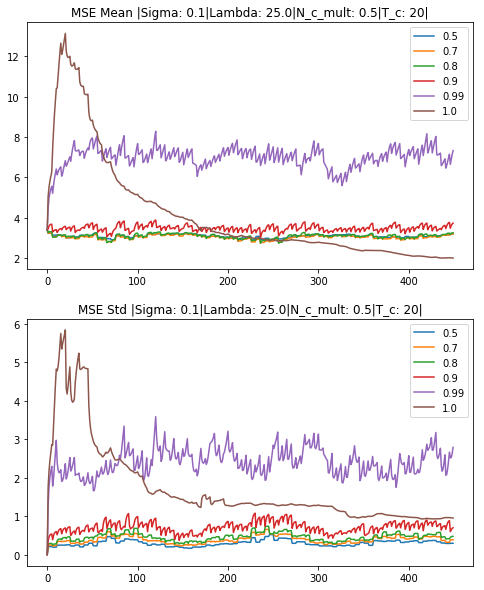

In [49]:
a,c,d,e = 0,6,1,2

fig,ax = plt.subplots(2,1,figsize=(8,10))
eta_mse_stds = pd.DataFrame([(np.std(np.linalg.norm(bandit_means[a,b,c,d,e] - Etas_fit,axis=-1),axis=0)) for b in range(len(gammas))]).T
eta_mse_stds.columns = gammas

eta_mse_means = pd.DataFrame([(np.mean(np.linalg.norm(bandit_means[a,b,c,d,e] - Etas_fit,axis=-1),axis=0)) for b in range(len(gammas))]).T
eta_mse_means.columns = gammas


eta_mse_means.plot(title = "MSE Mean " + params_print(a,None,c,d,e),ax=ax[0])
eta_mse_stds.plot(title = "MSE Std " + params_print(a,None,c,d,e),ax=ax[1])

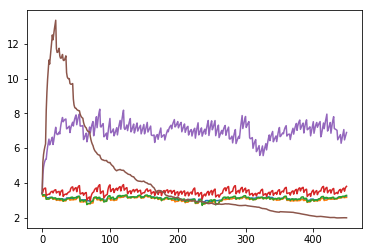

In [154]:
for b in range(len(gammas)):
    pd.Series((np.mean(np.linalg.norm(bandit_means[a,b,c,d,e] - Etas_fit,axis=-1),axis=0))).plot()

In [145]:
(bandit_means[a,b,c,d,e] - Etas_fit).shape

(55, 450, 11)

In [65]:
# TEST BAD2 PRIOR
prior_mdl = model(np.random.normal(size = ((nInteract+nBaseline,1)),scale = 2),np.eye(nInteract+nBaseline))

prior_cov_mult = [0.1,0.5,1.,2.,10.]
sigmas = [0.10,0.5, 1., np.nanstd(resids),10.]
gammas = [0.5,0.7,0.8,0.9,0.99,1.]
lambdas = [0.25, 0.5, 0.75, 1.,5.,10.,25.,100.]
N_c_mults = [0.25, 0.5, 0.75]
T_cs = [5, 10, 20, 50, 70]
T_cs_new = [30, 90,120,140,180,210,420,630]

regrets_bad2 = np.empty((len(sigmas), len(gammas), len(lambdas), len(N_c_mults), len(T_cs),N_new, T_new*t))
probs_bad2 = np.empty((len(sigmas), len(gammas), len(lambdas), len(N_c_mults), len(T_cs),N_new, T_new*t))
actions_bad2 = np.empty((len(sigmas), len(gammas), len(lambdas), len(N_c_mults), len(T_cs),N_new, T_new*t))
opts_bad2 = np.empty((len(sigmas), len(gammas), len(lambdas), len(N_c_mults), len(T_cs),N_new, T_new*t))
bandit_means_bad2 = np.empty((len(sigmas), len(gammas), len(lambdas), len(N_c_mults), len(T_cs),N_new, T_new*t, 11))

for a in range(len(sigmas)):
    sigma = sigmas[a]
    for b in range(len(gammas)):
        print(str(((a*len(gammas) + b)/(len(gammas)*len(sigmas)))*100) + "%, " + str(datetime.datetime.now()))
        gamma = gammas[b]
        for c in range(len(lambdas)):
            lamb = lambdas[c]
            for d in range(len(N_c_mults)):
                N_c_mult = N_c_mults[d]
                for e in range(len(T_cs)):
                    T_c = T_cs[e]
                    fc_params = [lamb, int(N_c_mult*T_c), T_c]
                    
                    regret, prob, action, opt, bandit_cov, bandit_mean, bandit = run_simulation(coef0 = Etas_fit[3:11], coef1 = Etas_fit[0:3], S_sim = S_new, I_sim = I_new, resids_sim = resids_new, reward_func = reward_func, fc_params = fc_params, prior_model = prior_mdl, gamma = gamma, sigma2=sigma)
                    regrets_bad2[a,b,c,d,e] = regret
                    probs_bad2[a,b,c,d,e] = prob
                    actions_bad2[a,b,c,d,e] = action
                    opts_bad2[a,b,c,d,e] = opt
                    bandit_means_bad2[a,b,c,d,e] = bandit_mean

0.0%, 2018-02-12 01:26:46.091226
3.3333333333333335%, 2018-02-12 01:43:09.270560
6.666666666666667%, 2018-02-12 01:59:04.734598
10.0%, 2018-02-12 02:15:07.139498
13.333333333333334%, 2018-02-12 02:31:07.223300
16.666666666666664%, 2018-02-12 02:47:02.956404
20.0%, 2018-02-12 03:02:49.153148
23.333333333333332%, 2018-02-12 03:18:41.634602
26.666666666666668%, 2018-02-12 03:34:38.549529
30.0%, 2018-02-12 03:50:29.071945
33.33333333333333%, 2018-02-12 04:06:33.805660
36.666666666666664%, 2018-02-12 04:22:23.476823
40.0%, 2018-02-12 04:38:12.627253
43.333333333333336%, 2018-02-12 04:54:07.751824
46.666666666666664%, 2018-02-12 05:10:13.255579
50.0%, 2018-02-12 05:26:13.548246
53.333333333333336%, 2018-02-12 05:42:12.451708
56.666666666666664%, 2018-02-12 05:58:06.800559
60.0%, 2018-02-12 06:13:47.873474
63.33333333333333%, 2018-02-12 06:29:46.428530
66.66666666666666%, 2018-02-12 06:45:45.272284
70.0%, 2018-02-12 07:01:46.878441
73.33333333333333%, 2018-02-12 07:17:43.133719
76.66666666666

In [66]:
np.save("regrets_bad2.npy",regrets_bad2)
np.save("probs_bad2.npy",probs_bad2)
np.save("actions_bad2.npy",actions_bad2)
np.save("opts_bad2.npy",opts_bad2)
np.save("bandit_means_bad2.npy",bandit_means_bad2)

Sigma: 0.1
Gamma: 0.5
Lambda: 0.25
N_c_mult: 0.25
T_c: 5


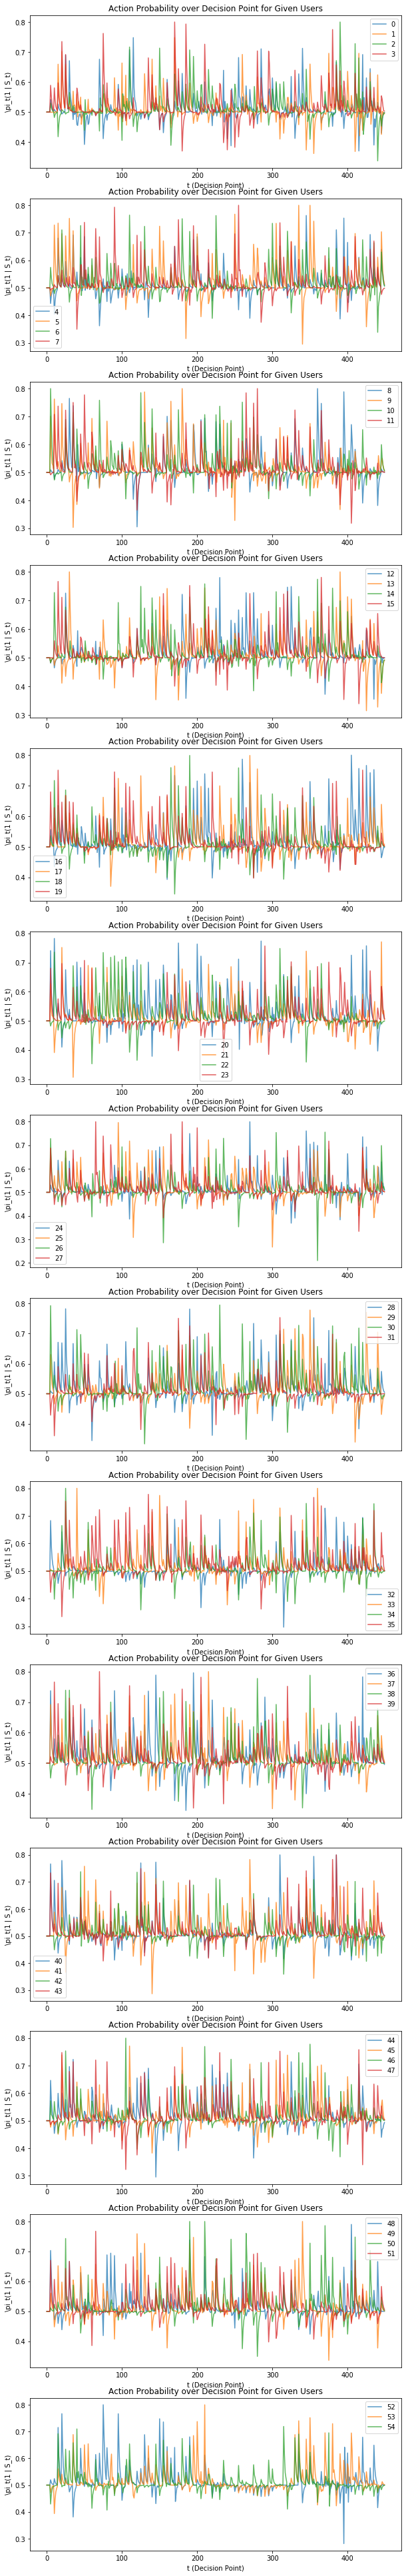

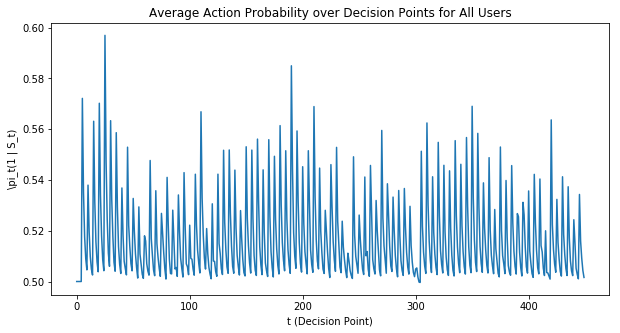

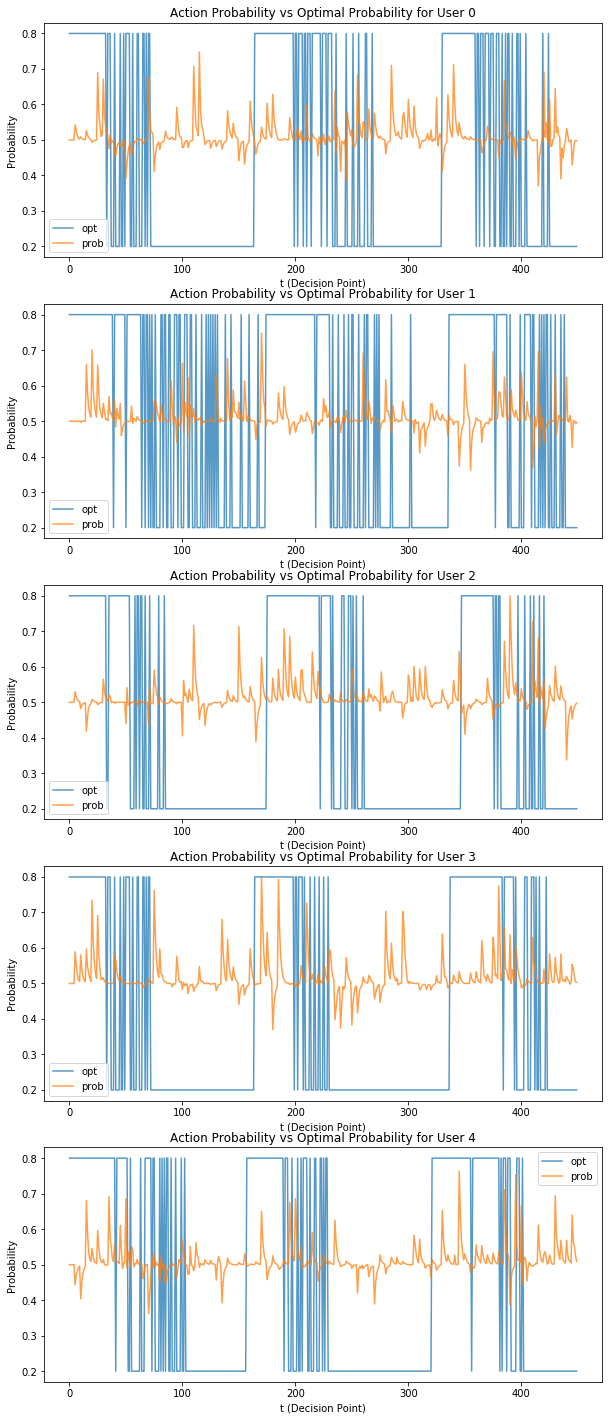

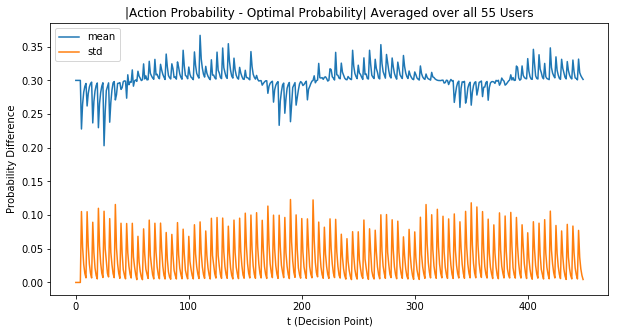

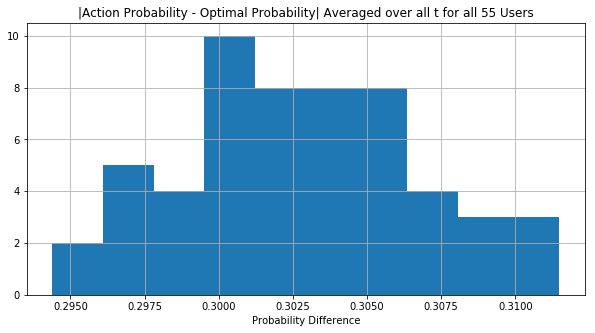

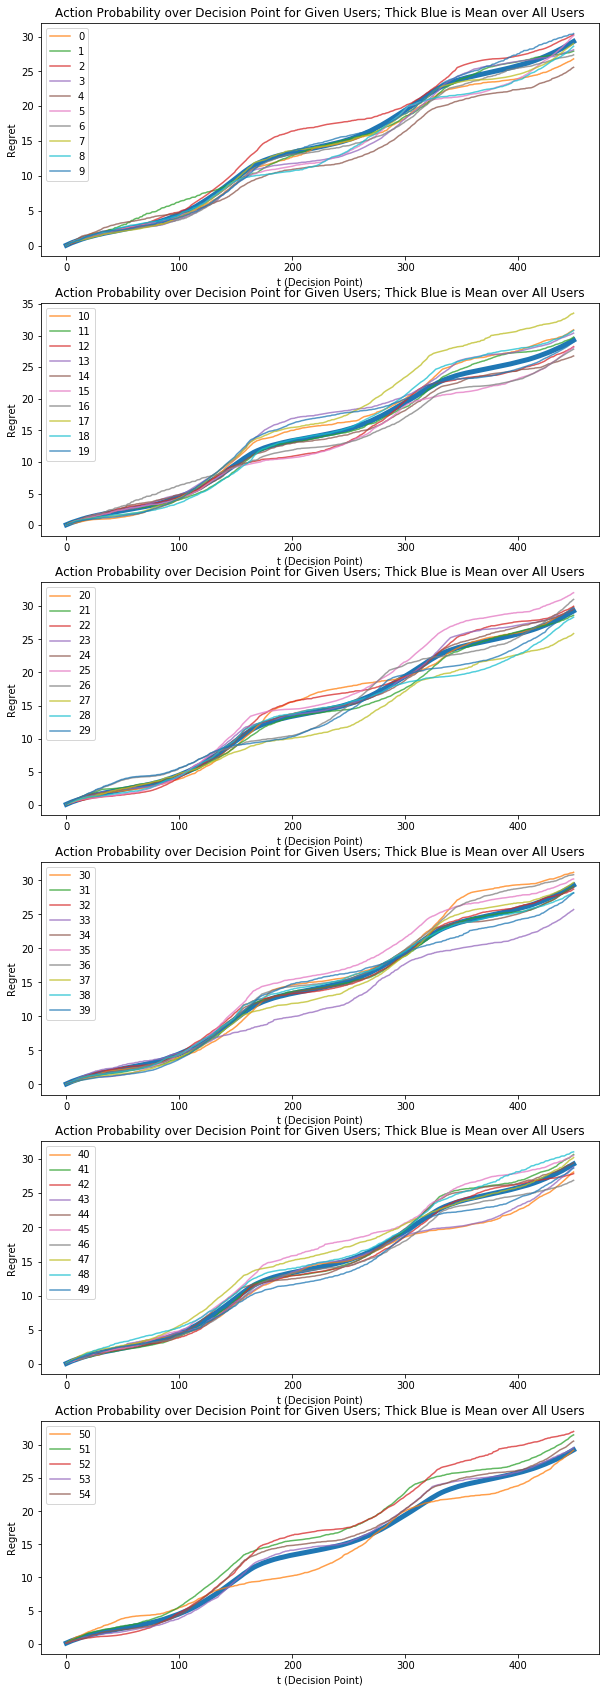

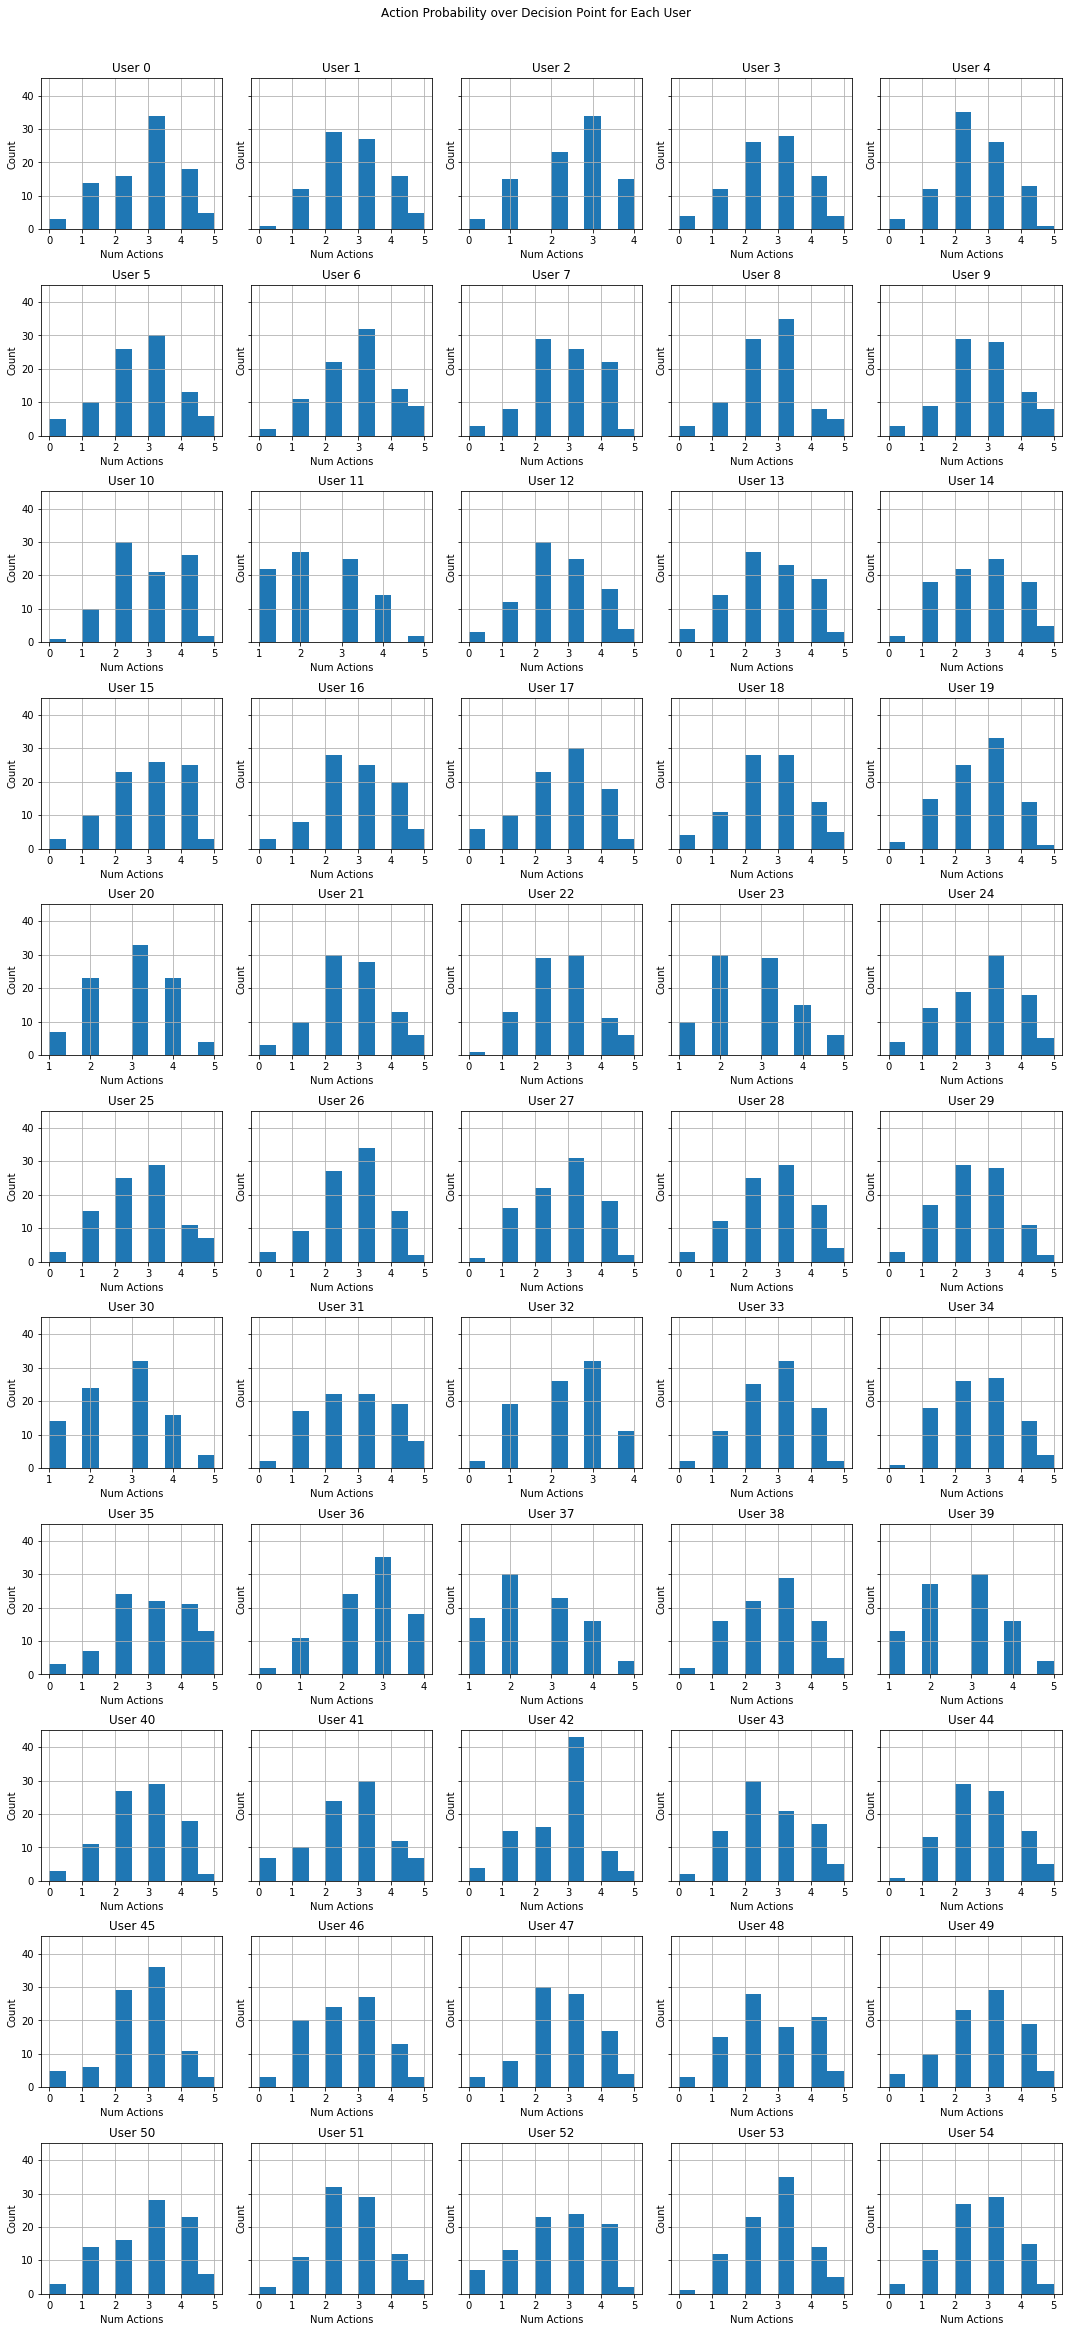

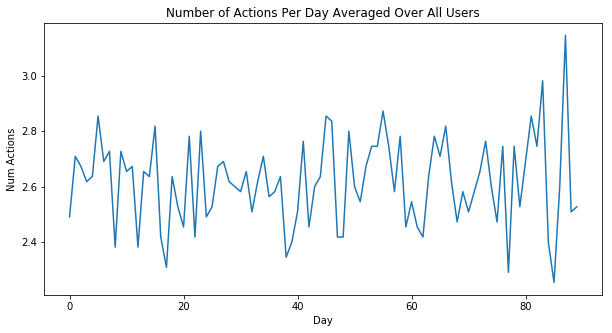

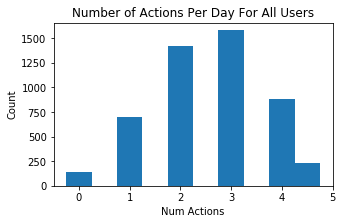

In [107]:
# Sigma, Gamma, lambda, N_c_mult, T_c
a,b,c,d,e = 0,0,0,0,0

print("Sigma:", sigmas[a])
print("Gamma:", gammas[b])
print("Lambda:", lambdas[c])
print("N_c_mult:", N_c_mults[d])
print("T_c:", T_cs[e])


regret, prob, action, opt = regrets[a,b,c,d,e], probs[a,b,c,d,e], actions[a,b,c,d,e], opts[a,b,c,d,e]

plot_QM1(regret, prob, action, opt) # Time series of action probability over decision points, per user
plot_QM1b(regret, prob, action, opt) # Time series of action probability over decision points, averaged across all users
plot_QM2(regret, prob, action, opt) # Time series of Prob vs Opt
plot_QM3(regret, prob, action, opt) # Time series of |prob - opt|, averaged across all users
plot_QM4(regret, prob, action, opt) # 
plot_QM5(regret, prob, action, opt)
plot_QM6a(regret, prob, action, opt)
plot_QM6b(regret, prob, action, opt)
plot_QM6c(regret, prob, action, opt)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000186B55657B8>]], dtype=object)

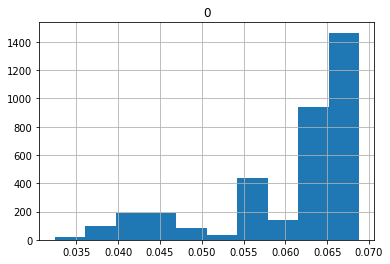

In [24]:
pd.DataFrame(regrets.mean(axis=-1).mean(axis=-1).flatten()).hist()

In [13]:
np.save("regrets.npy",regrets)
np.save("probs.npy",probs)
np.save("actions.npy",actions)
np.save("opts.npy",opts)
np.save("bandit_means.npy",bandit_means)

In [103]:
a,b,c,d,e = [],[],[],[],[]
for i in itertools.product(gammas, lambdas, N_c_mults, T_cs,sigmas):
    a.append(i[0])
    b.append(i[1])
    c.append(i[2])
    d.append(i[3])
    e.append(i[4])
    
indices = pd.DataFrame({"gamma":a, "lambda": b, "N_c_mult" : c, "T_c" : d,"sigma":e})

In [80]:
results["regret_means"]

array([[[[[ 0.06508516,  0.06490671,  0.06509801,  0.06489585,  0.06494973],
          [ 0.06508465,  0.06513097,  0.06524977,  0.06511808,  0.06503309],
          [ 0.06523847,  0.06507989,  0.06504831,  0.06496287,  0.06509117]],

         [[ 0.06508269,  0.06495709,  0.06509299,  0.06512247,  0.0651096 ],
          [ 0.06513485,  0.06502298,  0.06510626,  0.06507665,  0.06537283],
          [ 0.06518531,  0.06517941,  0.06519549,  0.06525333,  0.06496807]],

         [[ 0.0651073 ,  0.06493503,  0.0651527 ,  0.0649591 ,  0.06510564],
          [ 0.06499662,  0.06491846,  0.06501098,  0.06524751,  0.06499624],
          [ 0.06491674,  0.06520356,  0.0650129 ,  0.06507031,  0.06514086]],

         ..., 
         [[ 0.0650637 ,  0.06509405,  0.06526002,  0.06539016,  0.06504284],
          [ 0.06510369,  0.06510913,  0.06517   ,  0.0651121 ,  0.06517295],
          [ 0.06528633,  0.06491505,  0.06528854,  0.0650398 ,  0.06509897]],

         [[ 0.06523079,  0.06514146,  0.06519961,  0.

In [81]:
results["regret_stds"]

array([[[[[ 0.04709441,  0.04708363,  0.04723362,  0.0470421 ,  0.04694613],
          [ 0.04706215,  0.04729482,  0.04752113,  0.04738281,  0.04725675],
          [ 0.04744825,  0.04729695,  0.04728621,  0.04704827,  0.0471232 ]],

         [[ 0.04730272,  0.04706948,  0.04729467,  0.04722732,  0.04741957],
          [ 0.04740102,  0.0472585 ,  0.04758457,  0.04721096,  0.04781659],
          [ 0.04741501,  0.04759538,  0.04749457,  0.04749559,  0.04721829]],

         [[ 0.04742   ,  0.04706155,  0.04734358,  0.04690237,  0.04728366],
          [ 0.04704967,  0.04701334,  0.04718702,  0.04763402,  0.04727225],
          [ 0.04705539,  0.04749935,  0.0471309 ,  0.04725345,  0.04751515]],

         ..., 
         [[ 0.04724306,  0.04728523,  0.04752087,  0.04774269,  0.04727736],
          [ 0.04710851,  0.04718664,  0.04741349,  0.04728599,  0.0473111 ],
          [ 0.04749013,  0.04690895,  0.04737876,  0.04702211,  0.04738219]],

         [[ 0.04754565,  0.04738293,  0.04730862,  0.

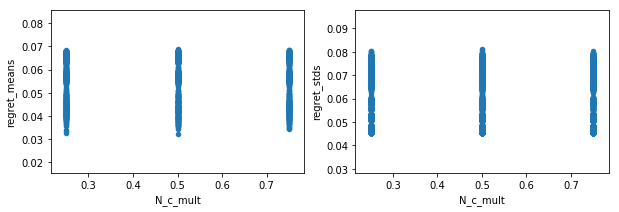

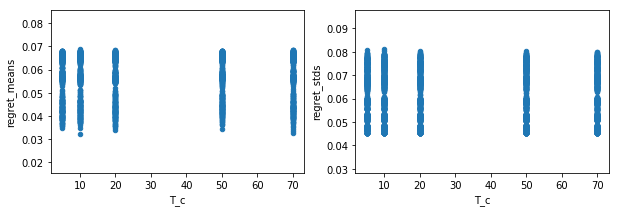

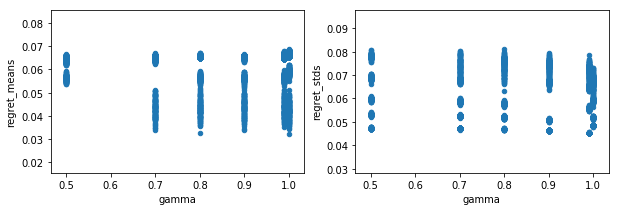

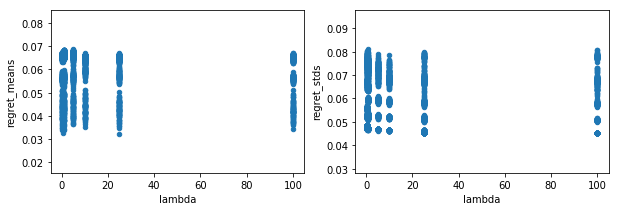

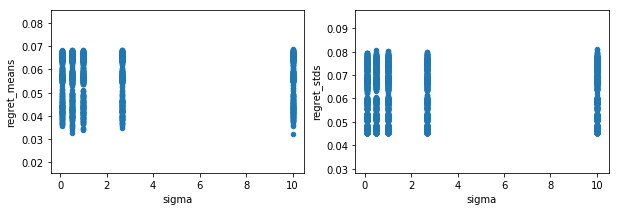

In [84]:
regret_results_means = regrets.reshape((len(sigmas), len(gammas), len(lambdas), len(N_c_mults), len(T_cs), N_new*T_new*t)).mean(axis=-1).flatten()
regret_results_stds = regrets.reshape((len(sigmas), len(gammas), len(lambdas), len(N_c_mults), len(T_cs), N_new*T_new*t)).std(axis=-1).flatten()

# probs_results_means =[np.mean(probs) for regret in regret_results]
# probs_results_stds = [np.sum(regret,axis = 1).std() for regret in regret_results]


results = {'regret_means': regret_results_means, 'regret_stds': regret_results_stds}

a = plot_params_vs_results(results, indices)


In [86]:
regret_results_means = regrets.reshape((len(sigmas), len(gammas), len(lambdas), len(N_c_mults), len(T_cs), N_new*T_new*t)).mean(axis=-1)

ValueError: Unrecognized marker style c

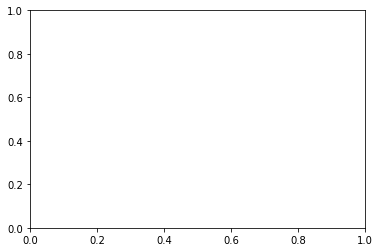

In [103]:
pd.Series(regret_results_means.mean(axis=(0,2,3,4))).plot(marker='c')

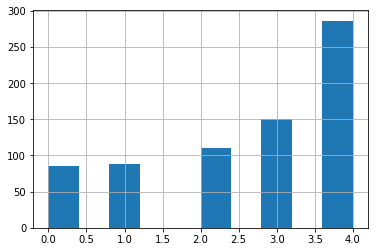

In [92]:
pd.Series(regret_results_means.argmax(axis=0).flatten()).hist()

In [70]:
def plot_params_vs_results(results, indices, figsize = (10,3)):
    results_df = pd.DataFrame(results)
    df_cat = pd.concat([indices, results_df], axis=1)

    cols = list(results.keys())
    param_names = indices.columns


    for param in param_names:
        fig, ax = plt.subplots(1,len(cols), figsize = figsize)
        for i,col in zip(range(len(cols)), cols):
            df_cat.plot(kind = 'scatter', x = param, y = col, ax = ax[i])
    
    return df_cat

In [106]:
plot_params_vs_results(regrets,indices)

ValueError: Must pass 2-d input

In [51]:
# Create indices


gammas = [0.1,0.5,0.7,0.8,0.9]
lambdas = [0.1, 0.25, 0.5, 0.75, 1., 10.]
N_c_mults = [0.1, 0.25, 0.5, 0.75, 0.9]
T_cs = [5, 10, 20, 35, 50, 70]
T_cs_new = [30, 90,120,140,180,210,420,630]

a,b,c,d = [],[],[],[]
for i in itertools.product(gammas, lambdas, N_c_mults, T_cs):
    a.append(i[0])
    b.append(i[1])
    c.append(i[2])
    d.append(i[3])

indices = pd.DataFrame({"gamma":a, "lambda": b, "N_c_mult" : c, "T_c" : d})

In [42]:
def plot_params_vs_results(results, indices, figsize = (10,3)):
    results_df = pd.DataFrame(results)
    df_cat = pd.concat([indices, results_df], axis=1)

    cols = list(results.keys())
    param_names = indices.columns


    for param in param_names:
        fig, ax = plt.subplots(1,len(cols), figsize = figsize)
        for i,col in zip(range(len(cols)), cols):
            df_cat.plot(kind = 'scatter', x = param, y = col, ax = ax[i])
    
    return df_cat

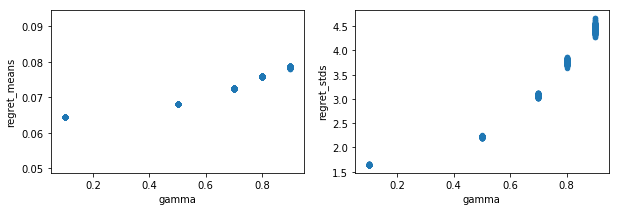

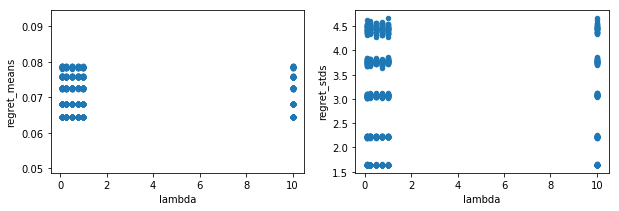

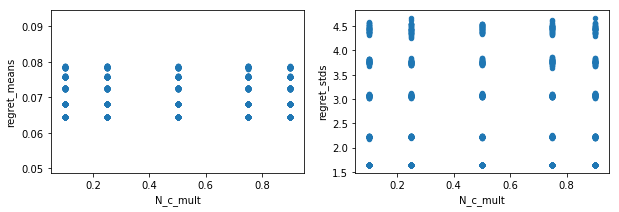

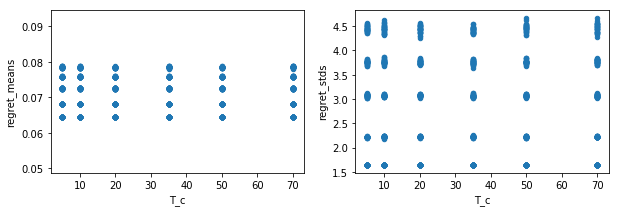

In [92]:
regret_results_means = [np.mean(regret) for regret in regret_results]
regret_results_stds = [np.sum(regret,axis = 1).std() for regret in regret_results]


results = {'regret_means': regret_results_means, 'regret_stds': regret_results_stds}

_ = plot_params_vs_results(results, indices)


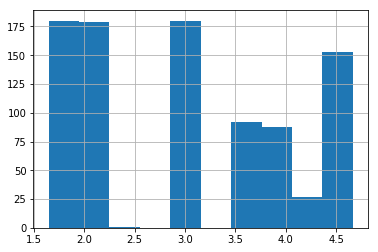

In [20]:
pd.Series(regret_results_stds).hist()

In [11]:
np.sum(regret_results[0],axis=1).mean()

29.045307368192784

In [11]:
bandit_means[:,-1,:].mean(axis=0)

array([ 3.10865709, -0.08888395,  0.10159862,  0.27720841,  1.22102856,
        0.35033489,  0.11793383,  0.26297994, -0.25819153, -0.02495706,
        0.15896695])

In [12]:
Etas_fit

array([-0.21181203, -0.16692167,  0.08116949,  3.04487594, -0.02305797,
        0.06443497,  0.18900795,  1.36208089,  0.30135504,  0.23107337,
        0.38301622])

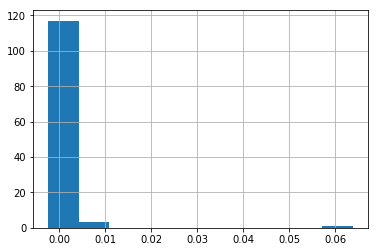

In [13]:
i = 14
pd.Series(bandit_covs[0][i*30].flatten()).hist()

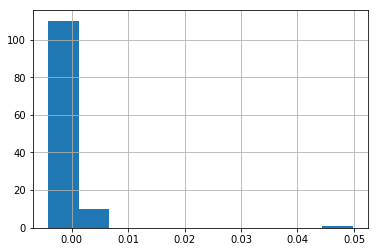

In [16]:
pd.Series(bandit.current_model.Sigma.flatten()).hist()

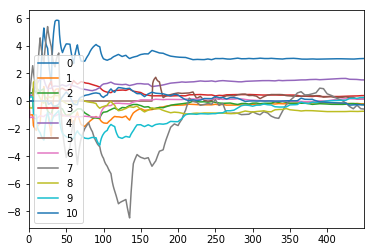

In [17]:
pd.DataFrame(bandit_means[0]).plot()

C:\Users\isaac\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


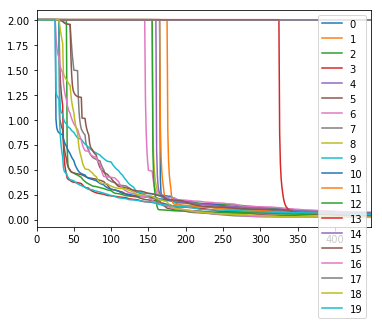

In [18]:
eigs = np.empty((N_new, T_new*t, 11))
for n in range(N_new):
    for time in range(T_new*t):
        eigs[n, time] = np.linalg.eigvals(bandit_covs[n, time])
pd.DataFrame(np.max(eigs,axis = -1)).T.plot()

In [ ]:
# Todo:

# Understand algorithm (Current Bandit, simulation data, generative model, tuning parameters etc)
# Future: How to generate data where features are based on prior actions?

# See difference between 1 user and averaged N>1 users

# First step: understand impact of \alpha based on quality metrics